# Detection Malicious URL Using ML Models

In [244]:
!pip install tld

<a id="1"></a> <br>
# 📥 Importing Libraries

In [245]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

#import library
from urllib.parse import urlparse


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from tld import get_tld, is_tld


# Load Dataset

In [246]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [247]:
data = pd.read_csv('/content/drive/MyDrive/malicious_phish.csv/malicious_phish.csv')
data.head(20)

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign
8,http://www.pashminaonline.com/pure-pashminas,defacement
9,allmusic.com/album/crazy-from-the-heat-r16990,benign


# Meta information of Dataframe

In [248]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


# Checking for NaN values

In [249]:
data.isnull().sum()

,0
url,0
type,0


In [250]:
count = data.type.value_counts()
count

,count
type,
benign,428103
defacement,96457
phishing,94111
malware,32520


In [251]:
x=count.index
x

Index(['benign', 'defacement', 'phishing', 'malware'], dtype='object', name='type')

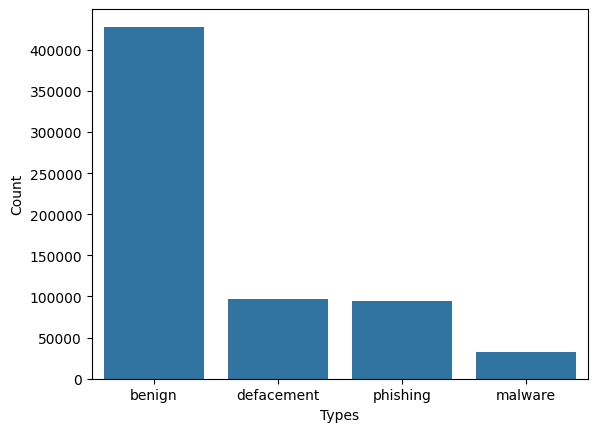

In [252]:
sns.barplot(x=count.index, y=count)
plt.xlabel('Types')
plt.ylabel('Count');

In [253]:
data['url'] = data['url'].replace('www.', '', regex=True)
data


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [254]:
data.head(10)

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign
8,http://pashminaonline.com/pure-pashminas,defacement
9,allmusic.com/album/crazy-from-the-heat-r16990,benign


In [255]:
rem = {"Category":{0: "Benign-Class 0", 1: "Defacement- Class 1", 2: "Phishing- Class 2", 3: "Malware- Class 3"}}
data['Category'] = data['type']
data = data.replace(rem)
data.head(20)

,url,type,Category
0,br-icloud.com.br,phishing,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement,defacement
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,benign
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,benign
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,benign
8,http://pashminaonline.com/pure-pashminas,defacement,defacement
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,benign


# Feature Extraction

In [256]:
data['url_len'] = data['url'].apply(lambda x: len(str(x)))

In [257]:
data.head()

,url,type,Category,url_len
0,br-icloud.com.br,phishing,phishing,16
1,mp3raid.com/music/krizz_kaliko.html,benign,benign,35
2,bopsecrets.org/rexroth/cr/1.htm,benign,benign,31
3,http://garage-pirenne.be/index.php?option=com_...,defacement,defacement,84
4,http://adventure-nicaragua.net/index.php?optio...,defacement,defacement,235


In [258]:
def process_tld(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain





In [259]:
data['domain'] = data['url'].apply(lambda i: process_tld(i))

In [260]:
data.head()

,url,type,Category,url_len,domain
0,br-icloud.com.br,phishing,phishing,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,benign,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,benign,31,bopsecrets.org
3,http://garage-pirenne.be/index.php?option=com_...,defacement,defacement,84,garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,defacement,235,adventure-nicaragua.net


In [261]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    data[a] = data['url'].apply(lambda i: i.count(a))

In [262]:
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,#,%,+,$,!,*,",",//
0,br-icloud.com.br,phishing,phishing,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,benign,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,benign,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,defacement,84,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,defacement,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1


In [263]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        return 1
    else:
        return 0



In [264]:
data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))

In [265]:
data.head(10)

,url,type,Category,url_len,domain,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url
0,br-icloud.com.br,phishing,phishing,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,benign,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,benign,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,defacement,84,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,defacement,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1,1
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,benign,118,buzzfil.net,0,0,16,0,2,0,0,0,0,0,0,0,1,1
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,benign,45,espn.go.com,0,0,1,0,2,0,0,0,0,0,0,0,0,0
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,benign,46,yourbittorrent.com,0,1,2,1,1,0,0,0,0,0,0,0,0,0
8,http://pashminaonline.com/pure-pashminas,defacement,defacement,40,pashminaonline.com,0,0,1,0,1,0,0,0,0,0,0,0,1,1
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,benign,45,allmusic.com,0,0,4,0,1,0,0,0,0,0,0,0,0,0


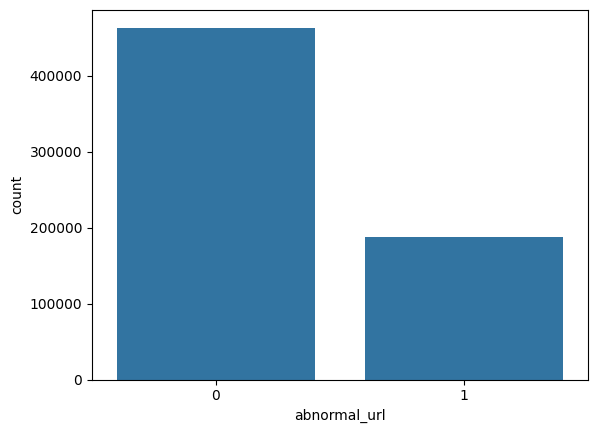

In [266]:
sns.countplot(x='abnormal_url', data=data);

In [267]:
def httpSecure(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        return 1
    else:
        return 0

In [268]:
data['https'] = data['url'].apply(lambda i: httpSecure(i))

In [269]:
data.head(20)

,url,type,Category,url_len,domain,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url,https
0,br-icloud.com.br,phishing,phishing,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,benign,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,benign,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,defacement,84,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1,1,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,defacement,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1,1,0
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,benign,118,buzzfil.net,0,0,16,0,2,0,0,0,0,0,0,0,1,1,0
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,benign,45,espn.go.com,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,benign,46,yourbittorrent.com,0,1,2,1,1,0,0,0,0,0,0,0,0,0,0
8,http://pashminaonline.com/pure-pashminas,defacement,defacement,40,pashminaonline.com,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,benign,45,allmusic.com,0,0,4,0,1,0,0,0,0,0,0,0,0,0,0


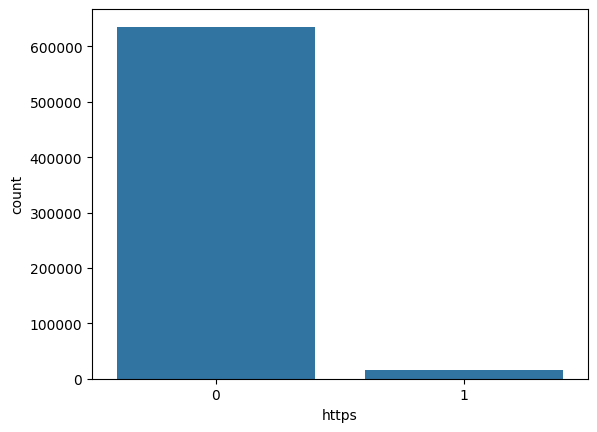

In [270]:
sns.countplot(x='https', data=data);

<h4>Counts the number of digit characters in a URL</h4>

In [271]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

In [272]:
data['digits']= data['url'].apply(lambda i: digit_count(i))

<h4>Counts the number of letter characters in a URL</h4>

In [273]:
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,%,+,$,!,*,",",//,abnormal_url,https,digits
0,br-icloud.com.br,phishing,phishing,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,benign,35,mp3raid.com,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1
2,bopsecrets.org/rexroth/cr/1.htm,benign,benign,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1
3,http://garage-pirenne.be/index.php?option=com_...,defacement,defacement,84,garage-pirenne.be,0,1,1,4,2,...,0,0,0,0,0,0,1,1,0,7
4,http://adventure-nicaragua.net/index.php?optio...,defacement,defacement,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,0,0,0,0,1,1,0,22


In [274]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters


In [275]:
data['letters']= data['url'].apply(lambda i: letter_count(i))

URL SHORTINING AND EXPANDING

In [276]:
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0


In [277]:
data['Shortining_Service'] = data['url'].apply(lambda x: Shortining_Service(x))

In [278]:
data.head(20)

,url,type,Category,url_len,domain,@,?,-,=,.,...,$,!,*,",",//,abnormal_url,https,digits,letters,Shortining_Service
0,br-icloud.com.br,phishing,phishing,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,0,0,0,0,13,0
1,mp3raid.com/music/krizz_kaliko.html,benign,benign,35,mp3raid.com,0,0,0,0,2,...,0,0,0,0,0,0,0,1,29,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,benign,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,0,0,0,0,1,25,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,defacement,84,garage-pirenne.be,0,1,1,4,2,...,0,0,0,0,1,1,0,7,60,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,defacement,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,0,0,1,1,0,22,199,0
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,benign,118,buzzfil.net,0,0,16,0,2,...,0,0,0,0,1,1,0,1,93,0
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,benign,45,espn.go.com,0,0,1,0,2,...,0,0,0,0,0,0,0,4,31,0
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,benign,46,yourbittorrent.com,0,1,2,1,1,...,0,0,0,0,0,0,0,0,40,1
8,http://pashminaonline.com/pure-pashminas,defacement,defacement,40,pashminaonline.com,0,0,1,0,1,...,0,0,0,0,1,1,0,0,34,0
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,benign,45,allmusic.com,0,0,4,0,1,...,0,0,0,0,0,0,0,5,33,0


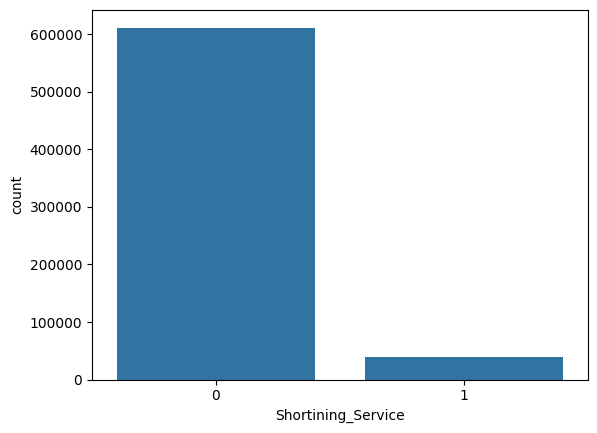

In [279]:
sns.countplot(x='Shortining_Service', data=data);

In [280]:
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

In [281]:
data['having_ip_address'] = data['url'].apply(lambda i: having_ip_address(i))

In [282]:
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,!,*,",",//,abnormal_url,https,digits,letters,Shortining_Service,having_ip_address
0,br-icloud.com.br,phishing,phishing,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,0,0,0,13,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,benign,35,mp3raid.com,0,0,0,0,2,...,0,0,0,0,0,0,1,29,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,benign,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,0,0,0,1,25,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,defacement,84,garage-pirenne.be,0,1,1,4,2,...,0,0,0,1,1,0,7,60,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,defacement,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,0,1,1,0,22,199,0,0


In [283]:
data['having_ip_address'].value_counts()

,count
having_ip_address,
0,638703
1,12488


<Axes: >

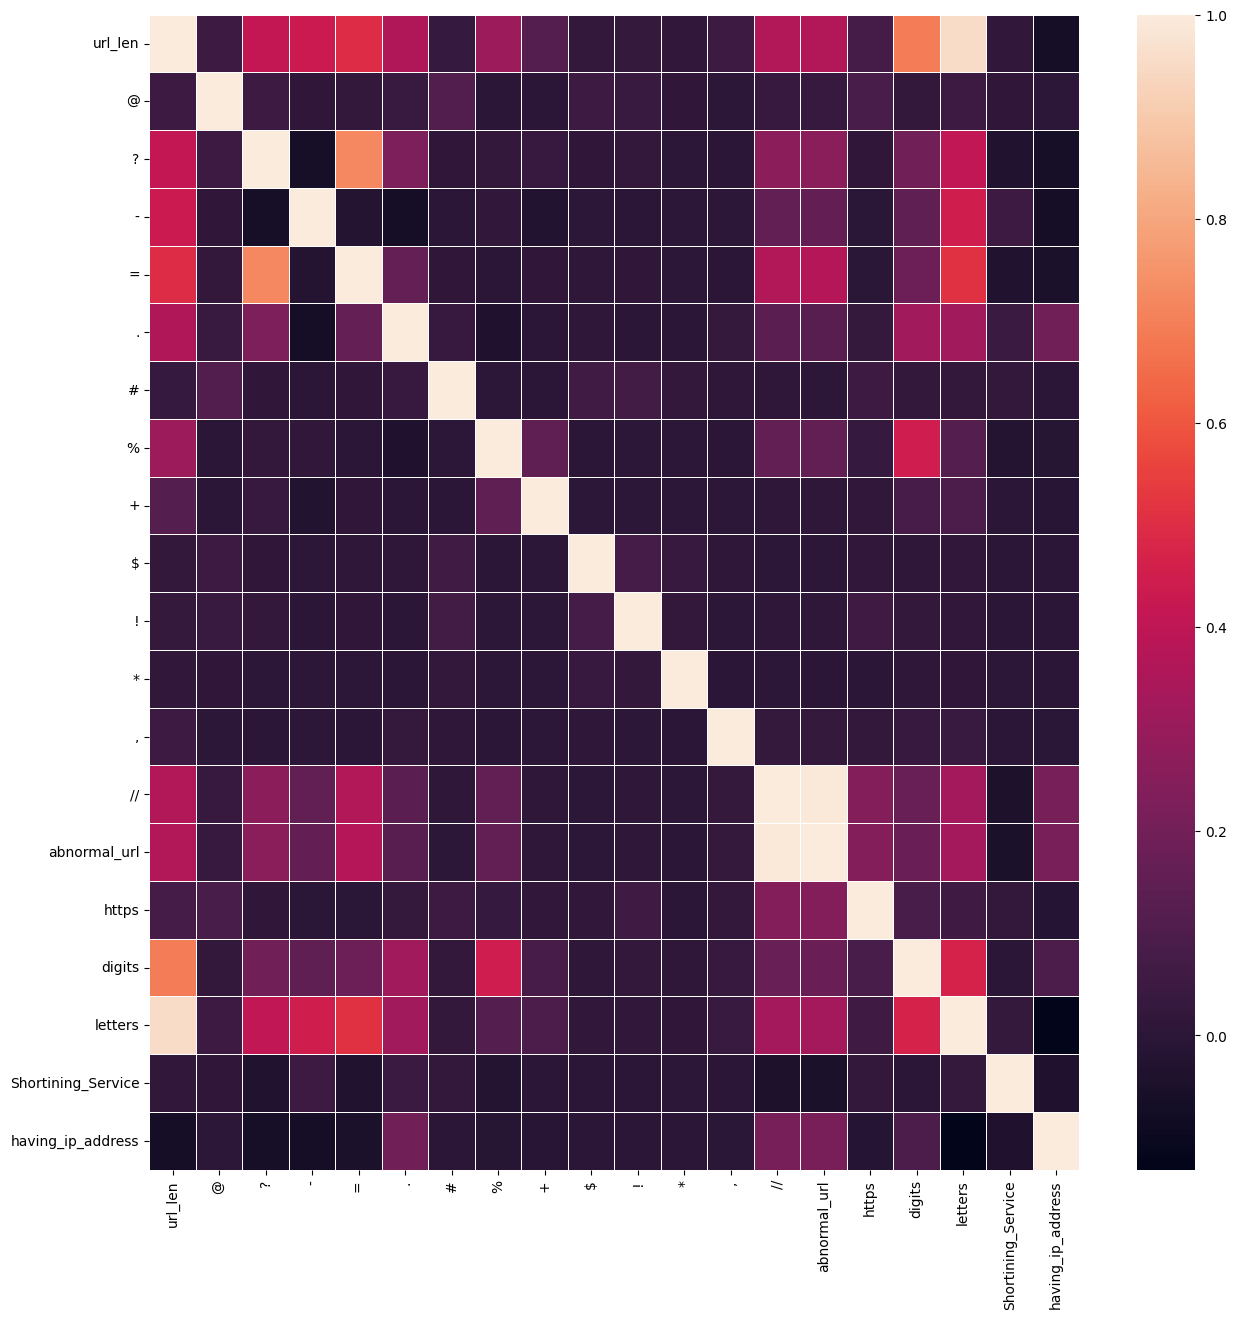

In [284]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.select_dtypes(include=np.number).corr(), linewidths=.5) # Select only numeric columns for correlation

In [285]:
X = data.drop(['url','type','Category','domain'],axis=1)
y = data['Category']

In [286]:
X

,url_len,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url,https,digits,letters,Shortining_Service,having_ip_address
0,16,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,13,0,0
1,35,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,29,0,0
2,31,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,25,0,0
3,84,0,1,1,4,2,0,0,0,0,0,0,0,1,1,0,7,60,0,0
4,235,0,1,1,3,2,0,0,0,0,0,0,0,1,1,0,22,199,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,39,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,12,21,0,0
651187,44,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,7,29,1,0
651188,38,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,30,1,0
651189,45,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,36,0,0


In [287]:
y

,Category
0,phishing
1,benign
2,benign
3,defacement
4,defacement
...,...
651186,phishing
651187,phishing
651188,phishing
651189,phishing


# Train & Test Split

In [288]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [289]:
X_train

,url_len,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url,https,digits,letters,Shortining_Service,having_ip_address
510482,31,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,26,0,0
194358,86,0,0,7,0,1,0,0,0,0,0,0,0,1,1,0,6,65,0,0
611258,90,0,1,0,2,2,0,0,0,0,0,0,0,0,0,0,6,73,0,0
417382,39,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,34,0,0
225565,80,0,0,8,0,1,0,0,0,0,0,0,0,0,0,0,0,69,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84434,41,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,9,29,0,0
437782,21,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,18,0,0
620104,44,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,8,27,0,0
203245,56,0,0,2,0,3,0,0,0,0,0,0,0,0,0,0,0,48,0,0


In [290]:
X_test

,url_len,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url,https,digits,letters,Shortining_Service,having_ip_address
238731,96,0,1,1,5,2,0,0,0,0,0,0,0,1,1,0,2,76,0,0
309364,84,0,1,1,3,2,0,0,0,0,0,0,0,0,0,0,13,59,0,0
170638,83,0,0,13,0,2,0,0,0,0,0,0,0,1,1,0,31,30,0,0
246063,14,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,12,0,0
466287,39,0,0,4,0,1,0,0,0,0,0,0,0,0,0,0,5,27,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348509,78,0,1,1,4,2,0,0,0,0,0,0,0,1,1,0,4,58,0,0
500295,28,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,25,0,0
53597,82,0,1,0,4,2,0,0,0,0,0,0,0,1,1,0,4,63,0,0
26012,26,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,22,0,0


In [291]:
y_train

,Category
510482,benign
194358,benign
611258,phishing
417382,benign
225565,benign
...,...
84434,benign
437782,benign
620104,phishing
203245,benign


In [292]:
y_test

,Category
238731,defacement
309364,benign
170638,defacement
246063,benign
466287,benign
...,...
348509,defacement
500295,benign
53597,defacement
26012,benign


###**Training** model

Test Accuracy :  91.48334984144533
              Classification_report 
              precision    recall  f1-score   support

      benign       0.92      0.98      0.95     85565
  defacement       0.94      0.97      0.95     19319
     malware       0.96      0.91      0.93      6550
    phishing       0.83      0.58      0.68     18805

    accuracy                           0.91    130239
   macro avg       0.91      0.86      0.88    130239
weighted avg       0.91      0.91      0.91    130239

             Confusion_matrix 


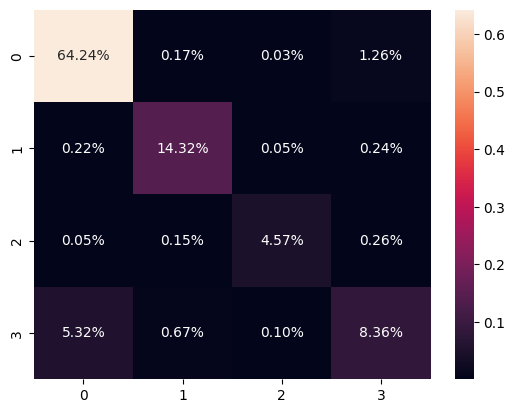

✅ Model saved successfully as 'random_forest_model.pkl'


In [293]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib

model = RandomForestClassifier()

model.fit(X_train, y_train)

pred = model.predict(X_test)

acc = accuracy_score(pred, y_test)

print('Test Accuracy : ',acc * 100)
print('\033[01m              Classification_report \033[0m')
print(classification_report(y_test, pred))
print('\033[01m             Confusion_matrix \033[0m')

cf_matrix = confusion_matrix(y_test, pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='0.2%')
plt.show()

joblib.dump(model, 'random_forest_model.pkl')

print("✅ Model saved successfully as 'random_forest_model.pkl'")


In [294]:
def URL_Converter(urls):
    data= pd.DataFrame()
    data['url'] = pd.Series(urls)


    data['url_len'] = data['url'].apply(lambda x: len(str(x)))
    data['domain'] = data['url'].apply(lambda i: process_tld(i))
    feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
    for a in feature:
        data[a] = data['url'].apply(lambda i: i.count(a))
    data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))
    data['https'] = data['url'].apply(lambda i: httpSecure(i))
    data['digits']= data['url'].apply(lambda i: digit_count(i))
    data['letters']= data['url'].apply(lambda i: letter_count(i))
    data['Shortining_Service'] = data['url'].apply(lambda x: Shortining_Service(x))
    data['having_ip_address'] = data['url'].apply(lambda i: having_ip_address(i))
    print(data.columns)
    X = data.drop(['url','domain'],axis=1)

    return X


In [295]:
urls= ['diaryofagameaddict.com',
'espdesign.com.au',
'iamagameaddict.com',
'kalantzis.net',
'slightlyoffcenter.net',
'toddscarwash.com',
'tubemoviez.com',
'ipl.hk',
'crackspider.us/toolbar/install.php?pack=exe',
'pos-kupang.com/',
'rupor.info',
'svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt',
'officeon.ch.ma/office.js?google_ad_format=728x90_as',
'sn-gzzx.com',
'sunlux.net/company/about.html',
'outporn.com',
'timothycopus.aimoo.com',
'xindalawyer.com',
'freeserials.spb.ru/key/68703.htm',
'deletespyware-adware.com',
'orbowlada.strefa.pl/text396.htm',
'ruiyangcn.com',
'zkic.com',
'adserving.favorit-network.com/eas?camp=19320;cre=mu&grpid=1738&tag_id=618&nums=FGApbjFAAA',
'cracks.vg/d1.php',
'juicypussyclips.com',
'nuptialimages.com',
'andysgame.com',
'bezproudoff.cz',
'ceskarepublika.net',
'hotspot.cz',
'gmcjjh.org/DHL',
'nerez-schodiste-zabradli.com',
'nordiccountry.cz',
'nowina.info',
'obada-konstruktiwa.org',
'otylkaaotesanek.cz',
'pb-webdesign.net',
'pension-helene.cz',
'podzemi.myotis.info',
'smrcek.com',
'spekband.com',
'm2132.ehgaugysd.net/zyso.cgi?18',
'webcom-software.ws/links/?153646e8b0a88',
'worldgymperu.com',
'zgsysz.com',
'oknarai.ru',
'realinnovation.com/css/menu.js']

In [296]:
test_data= URL_Converter(urls)

Index(['url', 'url_len', 'domain', '@', '?', '-', '=', '.', '#', '%', '+', '$',
       '!', '*', ',', '//', 'abnormal_url', 'https', 'digits', 'letters',
       'Shortining_Service', 'having_ip_address'],
      dtype='object')


In [297]:
pip install shap matplotlib


In [298]:
from IPython.display import FileLink

# Create a download link
display(FileLink('random_forest_model.pkl'))


/content/random_forest_model.pkl

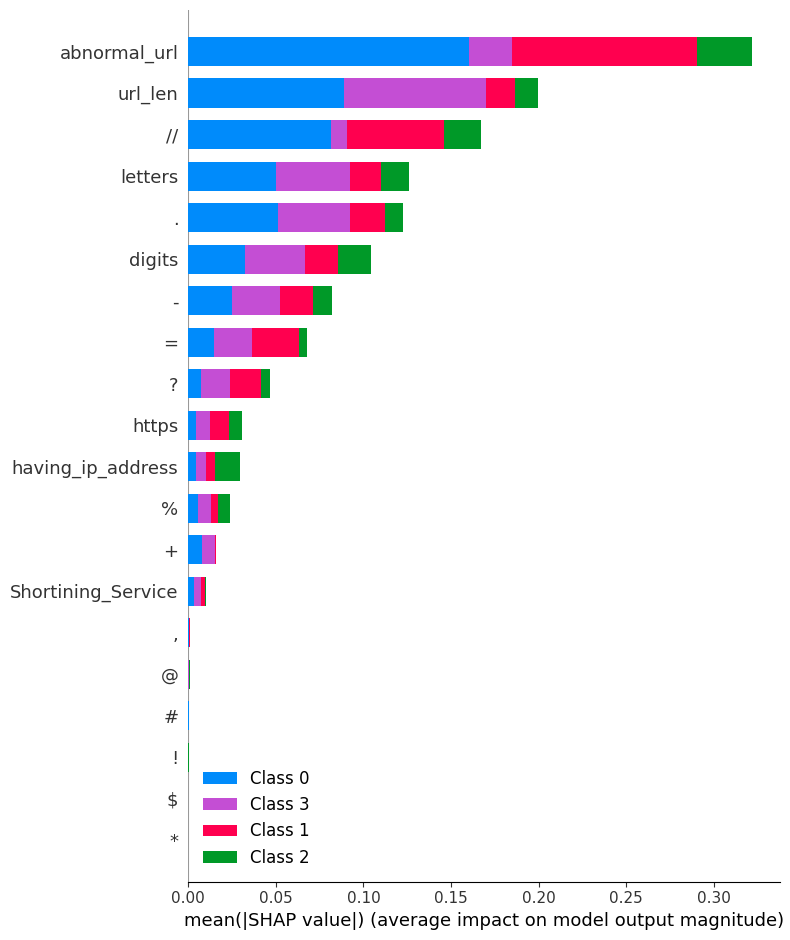

In [299]:
import shap
import joblib

# Load the saved model
loaded_model = joblib.load('random_forest_model.pkl')

X_sample = X_test.sample(100, random_state=42)

explainer = shap.TreeExplainer(loaded_model, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_sample)

# Summary plot (bar)
shap.summary_plot(shap_values, X_sample, plot_type="bar")

shap.initjs()



In [300]:
import joblib
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from urllib.parse import urlparse

model = joblib.load('random_forest_model.pkl')

feature_names = model.feature_names_in_

explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")

def extract_features(url):
    data = pd.DataFrame(columns=['url'])
    data.loc[0, 'url'] = url

    data['url_len'] = data['url'].apply(lambda x: len(str(x)))
    data['digits'] = data['url'].apply(lambda i: sum(c.isdigit() for c in i))
    data['letters'] = data['url'].apply(lambda i: sum(c.isalpha() for c in i))
    data['Shortining_Service'] = data['url'].apply(lambda x: Shortining_Service(x))
    data['having_ip_address'] = data['url'].apply(lambda i: having_ip_address(i))

    feature = ['@', '?', '-', '=', '.', '#', '%', '+', '$', '!', '*', ',', '//']
    for a in feature:
        data[a] = data['url'].apply(lambda i: i.count(a))

    data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))
    data['https'] = data['url'].apply(lambda i: httpSecure(i))

    X = data.drop(['url'], axis=1)

    X = X[feature_names]
    return X.iloc[0].values


def predict_and_explain(url):
    features = extract_features(url)
    features_array = np.array(features).reshape(1, -1)
    input_df = pd.DataFrame(features_array, columns=feature_names)

    prediction = model.predict(features_array)[0]

    shap_values = explainer.shap_values(input_df)

    plt.figure()
    shap.summary_plot(shap_values, input_df, plot_type="bar", show=False)
    plt.savefig("summary_plot.png", bbox_inches="tight")
    plt.close()



    return f"Predicted Class: {prediction}", "summary_plot.png"

url = "http://garage-pirenne.be/index.php?option=com"
prediction, summary_plot = predict_and_explain(url)

print(prediction)
print("Summary Plot saved as:", summary_plot)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Predicted Class: defacement
Summary Plot saved as: summary_plot.png


In [301]:
!pip install gradio


In [302]:
import joblib
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import gradio as gr
from urllib.parse import urlparse
rem = {"Category": {0: "Benign", 1: "Defacement", 2: "Phishing", 3: "Malware"}}

# Load the trained model
model = joblib.load('/content/random_forest_model.pkl')
feature_names = model.feature_names_in_
explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")

def extract_features(url):
    data = pd.DataFrame(columns=['url'])
    data.loc[0, 'url'] = url

    data['url_len'] = data['url'].apply(lambda x: len(str(x)))
    data['digits'] = data['url'].apply(lambda i: sum(c.isdigit() for c in i))
    data['letters'] = data['url'].apply(lambda i: sum(c.isalpha() for c in i))
    data['Shortining_Service'] = data['url'].apply(lambda x: Shortining_Service(x))
    data['having_ip_address'] = data['url'].apply(lambda i: having_ip_address(i))

    feature = ['@', '?', '-', '=', '.', '#', '%', '+', '$', '!', '*', ',', '//']
    for a in feature:
        data[a] = data['url'].apply(lambda i: i.count(a))

    data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))
    data['https'] = data['url'].apply(lambda i: httpSecure(i))

    X = data.drop(['url'], axis=1)
    X = X[feature_names]
    return X.iloc[0].values

def predict_and_explain(url):
    features = extract_features(url)
    features_array = np.array(features).reshape(1, -1)
    input_df = pd.DataFrame(features_array, columns=feature_names)

    prediction = model.predict(features_array)[0]

    shap_values = explainer.shap_values(input_df)

    plt.figure()
    shap.summary_plot(shap_values, input_df, plot_type="bar", show=False)
    plt.savefig("summary_plot.png", bbox_inches="tight")
    plt.close()

    return f"Predicted Class: {prediction}", "summary_plot.png"


interface = gr.Interface(
    fn=predict_and_explain,
    inputs=gr.Textbox(lines=1, placeholder="Enter URL here..."),
    outputs=["text", "image"],
    title="URL Classifier with SHAP Explanation",
    description="Paste a URL and find out if it's safe or suspicious, with SHAP feature importance!",
    theme=gr.themes.Monochrome(),  # keep your theme
    css="""
    .gradio-container {
        background: linear-gradient(to right, #00c6ff, #0072ff);
    }
    """
)

# Launch
interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ad6650225020557dad.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
